# Electricity Dataset

https://paperswithcode.com/dataset/electricity

In [93]:
%matplotlib inline

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from darts import TimeSeries

In [111]:
# Load data from data/household_power_consumption.txt:
# Date;Time;Global_active_power;Global_reactive_power;Voltage;Global_intensity;Sub_metering_1;Sub_metering_2;Sub_metering_3
# 16/12/2006;17:24:00;4.216;0.418;234.840;18.400;0.000;1.000;17.000

# /var/folders/94/znsw9kds1yddq0fywmh99mt40000gn/T/ipykernel_78150/4231314181.py:5: DtypeWarning: Columns (2,3,4,5,6,7) have mixed types. Specify dtype option on import or set low_memory=False.
#   df = pd.read_csv('data/household_power_consumption.txt', sep=';', parse_dates={'ds': ['Date', 'Time']})
# /var/folders/94/znsw9kds1yddq0fywmh99mt40000gn/T/ipykernel_78150/4231314181.py:5: UserWarning: Parsing dates in %d/%m/%Y %H:%M:%S format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
#   df = pd.read_csv('data/household_power_consumption.txt', sep=';', parse_dates={'ds': ['Date', 'Time']})
# , dtype={'Global_active_power': np.float64}
df = pd.read_csv('data/household_power_consumption.txt', sep=';', parse_dates={'ds': ['Date', 'Time']})
df = df[['ds', 'Global_active_power']]

/var/folders/94/znsw9kds1yddq0fywmh99mt40000gn/T/ipykernel_78150/4228857900.py:10: DtypeWarning: Columns (2,3,4,5,6,7) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('data/household_power_consumption.txt', sep=';', parse_dates={'ds': ['Date', 'Time']})
/var/folders/94/znsw9kds1yddq0fywmh99mt40000gn/T/ipykernel_78150/4228857900.py:10: UserWarning: Parsing dates in %d/%m/%Y %H:%M:%S format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  df = pd.read_csv('data/household_power_consumption.txt', sep=';', parse_dates={'ds': ['Date', 'Time']})


In [112]:
df['Global_active_power'] = pd.to_numeric(df['Global_active_power'], errors='coerce')

EVERY_N_ROWS = 60

# get every 10th row
# df = df.groupby(df.index // EVERY_N_ROWS).mean()

df.head(100)

,ds,Global_active_power
0,2006-12-16 17:24:00,4.216
1,2006-12-16 17:25:00,5.360
2,2006-12-16 17:26:00,5.374
3,2006-12-16 17:27:00,5.388
4,2006-12-16 17:28:00,3.666
...,...,...
95,2006-12-16 18:59:00,4.224
96,2006-12-16 19:00:00,4.070
97,2006-12-16 19:01:00,3.612
98,2006-12-16 19:02:00,3.458


In [113]:
# count NA values
df.isna().sum() / len(df)

ds                     0.000000
Global_active_power    0.012518
dtype: float64

In [114]:
# fill NA values with the previous value
df = df.ffill()

## Load time series data

In [115]:
TRAIN_DAYS = 7
PREDICTION_HOURS = 24

In [119]:
series = TimeSeries.from_dataframe(df, time_col='ds', value_cols='Global_active_power', fill_missing_dates=True, freq=None)
series = series.slice_n_points_before(series.end_time(), TRAIN_DAYS*24*60)

from darts.dataprocessing.transformers import WindowTransformer

transformer = WindowTransformer()
transformed_series = transformer.fit_transform(series)

TypeError: WindowTransformer.__init__() missing 1 required positional argument: 'transforms'

<Axes: xlabel='ds'>

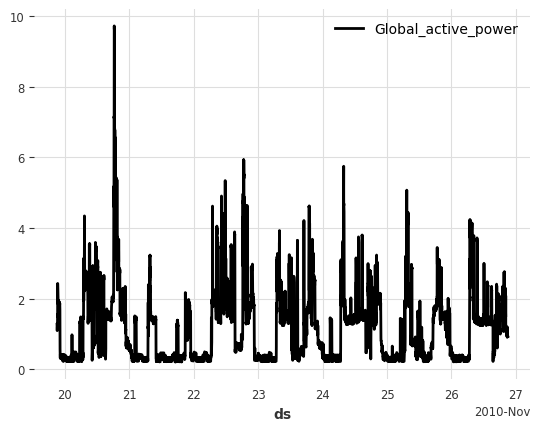

In [ ]:
series.plot()

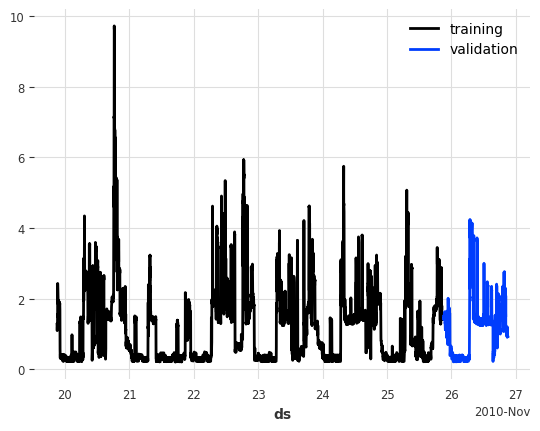

In [ ]:
train, val = series.split_after(6/7)
train.plot(label="training")
val.plot(label="validation")

to_predict = len(val)

## Baseline Model

<Axes: xlabel='ds'>

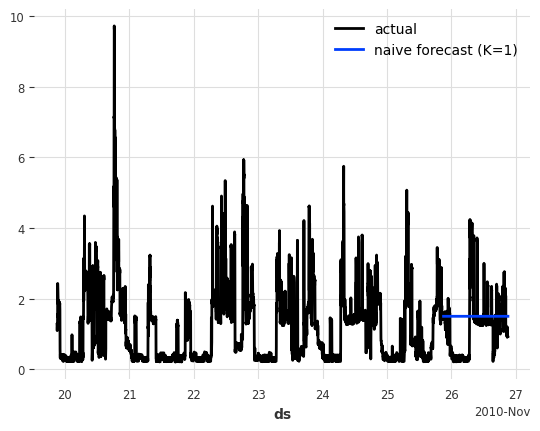

In [ ]:
from darts.models import NaiveSeasonal

naive_model = NaiveSeasonal(K=1)
naive_model.fit(train)
naive_forecast = naive_model.predict(to_predict)

series.plot(label="actual")
naive_forecast.plot(label="naive forecast (K=1)")

In [ ]:
# TODO: Fix this model
from darts.models.forecasting.xgboost import XGBModel

xgb_model = XGBModel(
    lags=24 * 60,
    output_chunk_length=100,
)

xgb_model.fit(train, verbose=True)

xgb_forecast = xgb_model.predict(to_predict)


/Users/jakubkosmydel/miniconda3/envs/rekomendacyjne/lib/python3.11/site-packages/sklearn/utils/deprecation.py:86: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
  warnings.warn(msg, category=FutureWarning)
/Users/jakubkosmydel/miniconda3/envs/rekomendacyjne/lib/python3.11/site-packages/sklearn/utils/parallel.py:114: UserWarning: `sklearn.utils.parallel.delayed` should be used with `sklearn.utils.parallel.Parallel` to make it possible to propagate the scikit-learn configuration of the current thread to the joblib workers.
  warnings.warn(


KeyboardInterrupt: 

<Axes: xlabel='ds'>

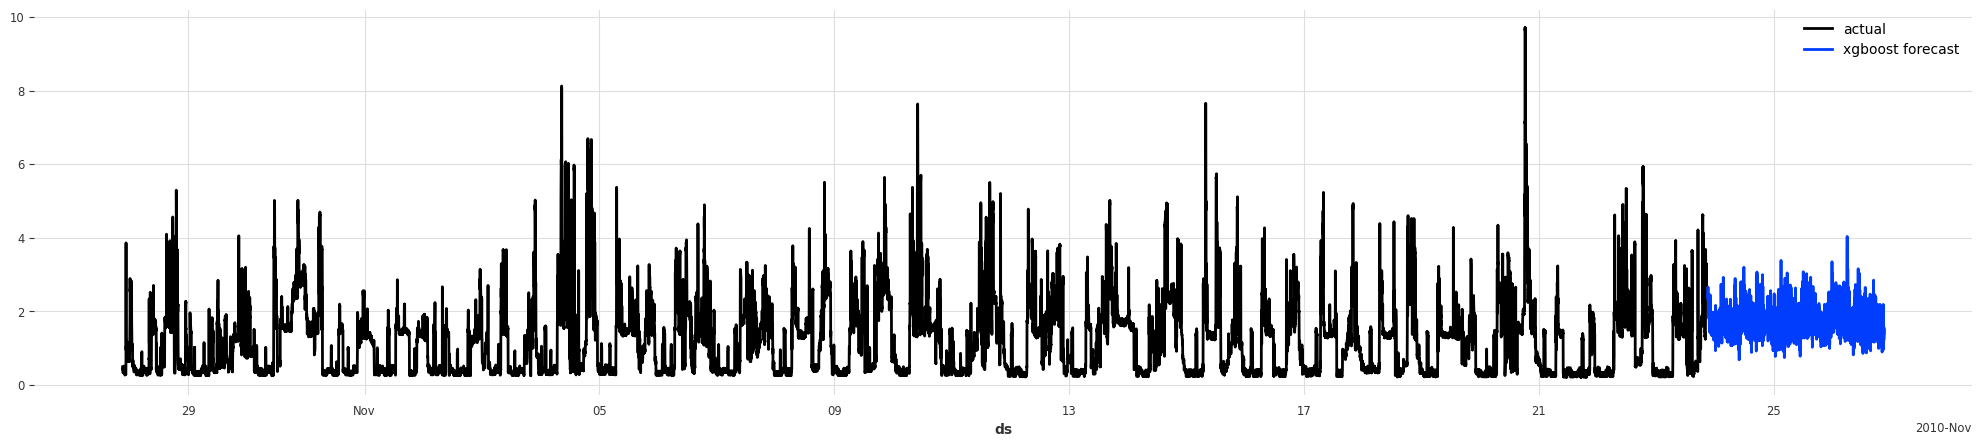

In [ ]:
plt.figure(figsize=(25,5))
train.plot(label="actual")
xgb_forecast.plot(label="xgboost forecast")

<Axes: xlabel='ds'>

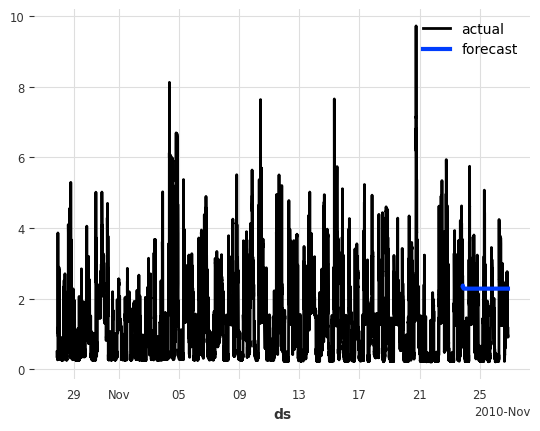

In [ ]:
# arima model
from darts.models import AutoARIMA

model = AutoARIMA(verbose=True)
model.fit(train)

prediction = model.predict(to_predict, verbose=True)

<Axes: xlabel='ds'>

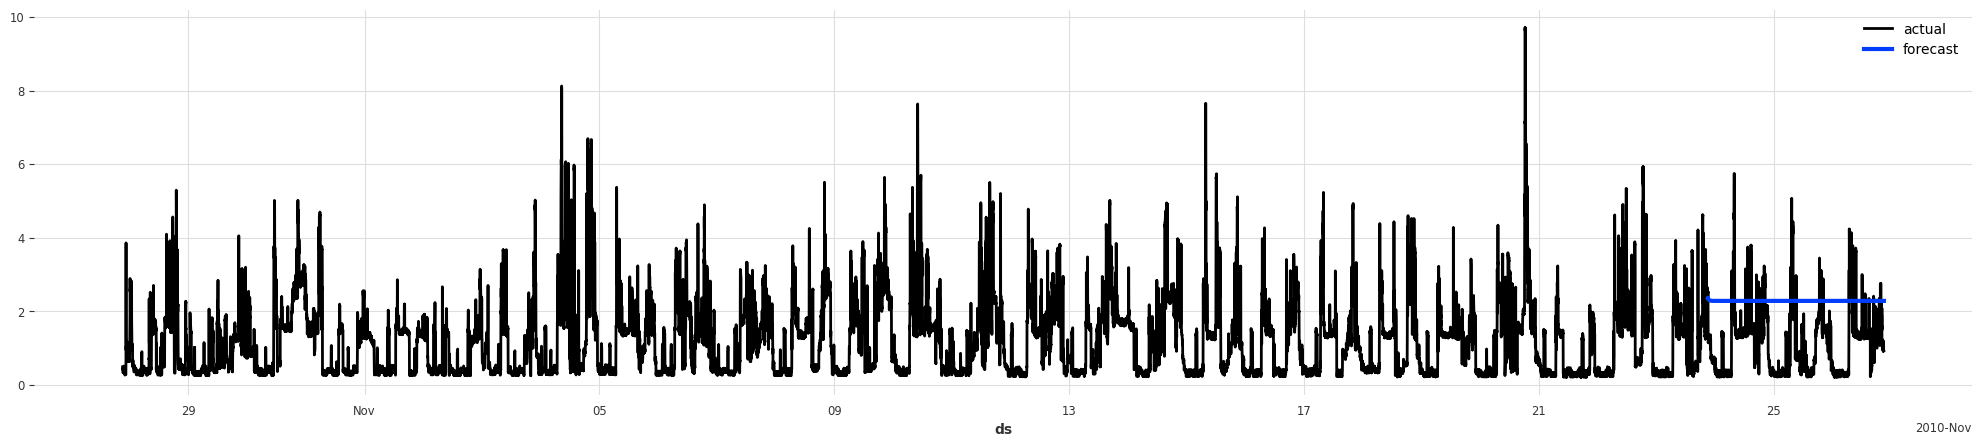

In [ ]:

plt.figure(figsize=(25,5))
series.plot(label='actual')
prediction.plot(label='forecast', lw=3)

In [ ]:
# exponential smoothing

from darts.models import ExponentialSmoothing

model_es = ExponentialSmoothing(seasonal_periods=7)
historical_fcast_es = model_es.historical_forecasts(
    series, start=0.9, verbose=True
)

series.plot(label="data")
historical_fcast_es.plot(label="backtest 3-months ahead forecast (Exp. Smoothing)")

  0%|          | 0/1009 [00:00<?, ?it/s]

KeyboardInterrupt: 